This code is © P. Sánchez and I. González, 2025, and it is made available under the GPL license enclosed with the software.

If you use this software in your research or projects, we kindly ask you to acknowledge our work by citing the following reference:

- Sánchez, P., González, I., Cortés, A., Carrillo, C., & Margalef, T. (2025). Airborne Hyperspectral Data Processing [Software]. Zenodo.
https://doi.org/10.5281/zenodo.14871861

This software was developed as part of the SALUS (CPP2021-008762) framework.

# Airborne Data (I)

## Accessing the Data for the Training

The data we will use is not public. It has been specifically provided to us for this training, so it is not directly available in the **GitLab** repository. Instead, we need to download it from a **Wekeo S3 bucket**. To access this data, you will need the following information, which is included in the code we will provide in a Jupyter Notebook.

### How to Access the Data?

1. **S3 Access Configuration:**
   To access the Wekeo bucket, you will need to use the provided credentials and endpoint. This will allow you to securely connect to the bucket from your local environment.

2. **Downloading the Files:**
   The files required for this training are located in the **`aerial-data`** folder within the **Practical Examples** bucket. By running the corresponding code in the Jupyter Notebook, you will be able to download all the files in this folder.

   The code will download the files while maintaining the directory structure on your local machine. Be sure to have enough storage space and a stable internet connection during the download.

### Important for the Case Studies

For the case studies, you will need to follow a similar process to download the data, but you will be accessing a different bucket. We will provide detailed information on the new bucket and the necessary prefix to correctly perform the download.

In [1]:
import os
import boto3

import credentials
# S3 Configuration

prefix = "aerial_data/"  # Folder prefix (e.g., "folder/subfolder/")
local_download_dir = "AirborneData/"

s3 = boto3.client(
    "s3",
    endpoint_url=credentials.S3_ENDPOINT,
    aws_access_key_id=credentials.S3_NERO_ACCESS_KEY,
    aws_secret_access_key=credentials.S3_NERO_SECRET_KEY,
)

# List objects under the specified prefix
response = s3.list_objects_v2(Bucket=credentials.S3_NERO_BUCKET_NAME, Prefix=prefix)

# Check if there are files under the prefix
if "Contents" in response:
    for obj in response["Contents"]:
        file_key = obj["Key"]  # Full S3 file path
        local_file_path = os.path.join(local_download_dir, file_key.replace(prefix, ""))

        # Ensure subdirectories exist locally
        os.makedirs(os.path.dirname(local_file_path), exist_ok=True)

        # Download the file
        print(f"Downloading {file_key} to {local_file_path}...")
        s3.download_file(credentials.S3_NERO_BUCKET_NAME, file_key, local_file_path)

    print("All files downloaded successfully!")
else:
    print("No files found under", prefix)

All files downloaded successfully!


## Data Processing and Standardization

The provided code is used to process and standardize two different remote sensing datasets: an **RGBN** dataset and a **LWIR** (Long-Wave Infrared) dataset. The main goal of this code is to align both datasets in terms of their spatial resolution, coordinate reference system (CRS), and the range of values, so they can be analyzed together. Below is an overview of what the code is doing in general:

### General Workflow

1. **Loading the Data**: 
   - The code opens two GeoTIFF files: one for the RGBN dataset (which includes Red, Green, Blue, and Near-Infrared bands) and another for the LWIR dataset. These files contain the respective raster data representing these spectral bands.

2. **Bounding Box Intersection**:
   - The code computes the intersection of the bounding boxes of both datasets to ensure that only the overlapping area of the two datasets is processed. This step is essential to avoid any issues that might arise from data misalignment.

3. **Reprojecting the LWIR Dataset**:
   - Since the datasets may have different spatial resolutions or coordinate reference systems (CRS), the LWIR dataset is resampled to match the resolution and CRS of the RGBN dataset. This ensures both datasets are aligned for further analysis.

4. **Reading and Normalizing the Data**:
   - Both the RGBN and LWIR bands are read as arrays. The RGBN bands (Red, Green, and NIR) are normalized by dividing the pixel values by 255, bringing them to a standard range of 0 to 1. Similarly, the resampled LWIR data is also normalized to this range. 

5. **Creating a Multi-Band GeoTIFF**:
   - The final step involves saving all the processed bands into a multi-band GeoTIFF file. This file will include the normalized RGBN and LWIR data in a format that can be used for further analysis.

### Standardization and Data Loss

In the datasets, all bands are standardized to a range between **0 and 255**, with an additional transparency layer that always has a value of 255, which is irrelevant to the analysis. This transparency layer is not used in the processing but is present in both datasets.

However, a significant concern arises from the fact that we do not know the exact process or methodology that was used to scale the data to this 0-255 range. As a result, important information could have been lost during the transformation, leading to potential inaccuracies in the analysis. The lack of transparency about the data preprocessing steps means we cannot be sure if any critical data was compressed or altered in a way that would affect the quality of our analysis.

This issue highlights a common challenge when working with non-public datasets that were not provided by a public entity with standardized and transparent processes. When data comes from private or proprietary sources, the lack of documentation on how the data was processed can lead to inconsistencies, making it harder to trust the results or reproduce them.

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from shapely.geometry import box

folder = "AirborneData/20240913175528/"

RGBN_tiff = folder + "RGBN.tiff"
thermal_tiff = folder + "LWIR.tiff"

# Load RGBN and LWIR datasets
with rasterio.open(RGBN_tiff) as src_rgbn, rasterio.open(thermal_tiff) as src_lwir:
    # Compute intersection of bounding boxes
    rgbn_bounds = box(*src_rgbn.bounds)
    lwir_bounds = box(*src_lwir.bounds)
    intersection = rgbn_bounds.intersection(lwir_bounds)
    
    if intersection.is_empty:
        raise ValueError("No overlapping area between RGBN and LWIR datasets.")
    
    # Read and reproject LWIR to match RGBN resolution and CRS
    lwir_resampled, _ = reproject(
        source=src_lwir.read(1),
        destination=np.empty((src_rgbn.height, src_rgbn.width), dtype=np.float32),
        src_transform=src_lwir.transform,
        src_crs=src_lwir.crs,
        dst_transform=src_rgbn.transform,
        dst_crs=src_rgbn.crs,
        resampling=Resampling.bilinear
    )
    
    # Read RGBN bands
    red = src_rgbn.read(1).astype(float) / 255  # Band 1 (Red)
    green = src_rgbn.read(2).astype(float) / 255  # Band 2 (Green)
    blue = src_rgbn.read(3).astype(float) / 255  # Band 3 (Blue)
    nir = src_rgbn.read(4).astype(float) / 255  # Band 4 (NIR)
    lwir = lwir_resampled / 255 # Use resampled LWIR
    
    # Save all indices as a multi-band GeoTIFF
    profile = src_rgbn.profile.copy()

output_tiff = folder + "LWIR_normalized.tiff"

profile.update(
    dtype=rasterio.float32,
    count=1,  # 1 band
    driver="GTiff",
    compress='LZW',  # Compression for smaller file size
    tiled=True  # Enable tiling for compatibility with GIS tools
)

# Save the ratio as a new TIFF file
with rasterio.open(output_tiff, "w", **profile) as dst:
    dst.write(lwir, 1)  # Write the ratio as the first band

print(f"LWIR normalized saved to {output_tiff}")

LWIR normalized saved to AirborneData/20240913175528/LWIR_normalized.tiff


## Importance of Fire Detection Indices

Fire-detection indices are critical tools used in remote sensing to identify and monitor active fires or fire-prone areas. These indices provide valuable insights into the thermal and spectral characteristics of fire-affected regions, allowing for better detection, analysis, and response to wildfire events. The indices we will compute here are particularly useful for distinguishing between fire and non-fire areas, and for assessing vegetation health and moisture content in the presence of fire. The indices we'll focus on include the **Burned Area Index (BAI)**, **Normalized Difference Vegetation Index (NDVI)**, and **Normalized Difference Water Index (NDWI)**.

Each of these indices relies on specific spectral bands, typically those related to visible light, infrared, and thermal wavelengths, which are sensitive to vegetation, water content, and temperature. By calculating and analyzing these indices, we can gain a better understanding of fire behavior, the extent of fire damage, and the recovery of affected vegetation.

### 1. Burned Area Index (BAI)

#### Formula:
$$
\text{BAI} = \frac{1}{( ( \text{Red} - 0.1)^2 + (\text{NIR} - 0.06)^2 )}
$$

### Explanation:
The **Burned Area Index (BAI)** is designed to highlight areas that have been burned by fire. It is a vegetation index that uses the difference between the red (visible light) and near-infrared (NIR) bands to detect changes in vegetation after a fire. Healthy vegetation typically reflects a lot of infrared light, but when it is burned, it reflects less infrared light and more visible red light. The formula calculates the inverse of the squared difference between the red and NIR bands, making it highly sensitive to burned areas.

### 2. Normalized Difference Vegetation Index (NDVI)

#### Formula:
$$
\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}}
$$

#### Explanation:
The **Normalized Difference Vegetation Index (NDVI)** is one of the most commonly used indices for vegetation monitoring. It measures the difference between the near-infrared (NIR) and red bands to assess vegetation health. Healthy vegetation has a high NDVI value, while barren or burned areas have a low or negative value. NDVI is effective for monitoring vegetation greenness and biomass, and it can indicate the extent of damage from fire.

### 3. Normalized Difference Water Index (NDWI)

#### Formula:
$$
\text{NDWI} = \frac{\text{Green} - \text{NIR}}{\text{NIR} + \text{Green}}
$$

#### Explanation:
The **Normalized Difference Water Index (NDWI)** is used to monitor water content in vegetation. It uses the green and near-infrared (NIR) bands to distinguish between water and non-water surfaces. Water absorbs green light and reflects infrared light, so NDWI values are positive for water-rich areas and negative for dry areas. This index can help detect moisture changes caused by fire or drought.

### Saving Each Index Separately

The indices are calculated and saved separately as individual GeoTIFF files. Each index is saved as a single-band raster to preserve the individual information for further analysis or visualization.

For each index, the following steps are performed:
1. The index is calculated based on the respective formula.
2. A new GeoTIFF file is created for each index.
3. The index is written to its corresponding file using the `rasterio` library.
4. Each index is saved with compression and tiling enabled to optimize file size and compatibility with GIS tools.

After saving the indices, you can visualize them using a plotting function that displays each index with appropriate color maps.

Index BAI saved to AirborneData/20240913175528/BAI_index.tiff
Index NDVI saved to AirborneData/20240913175528/NDVI_index.tiff
Index NDWI saved to AirborneData/20240913175528/NDWI_index.tiff


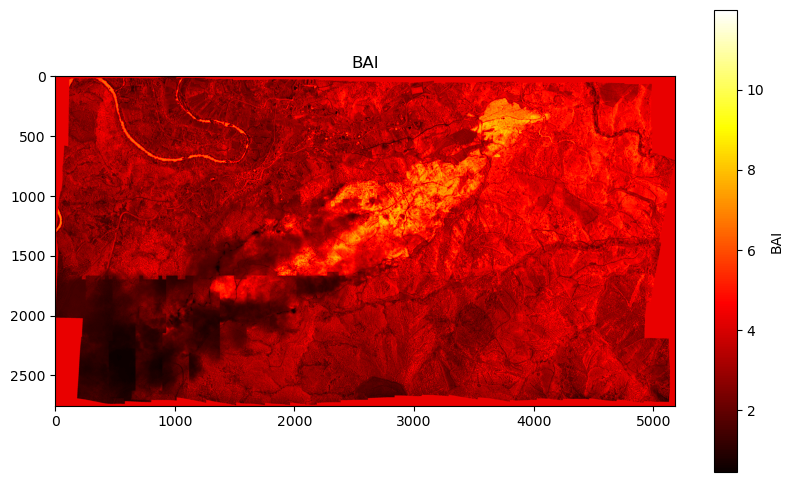

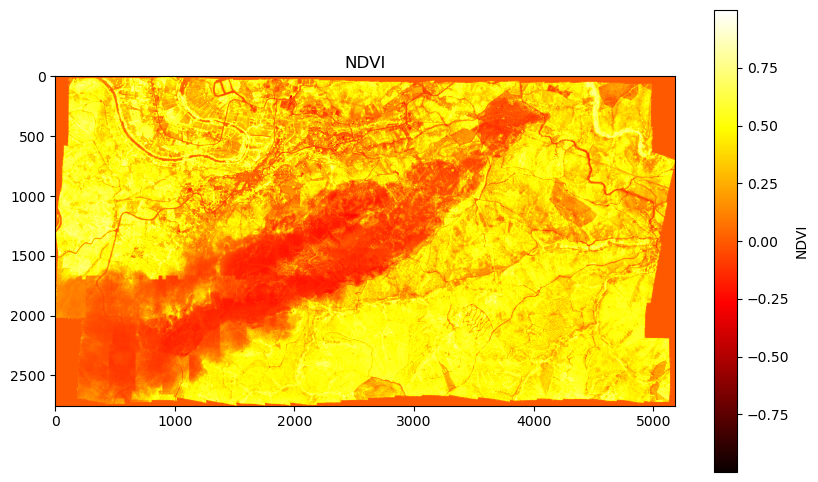

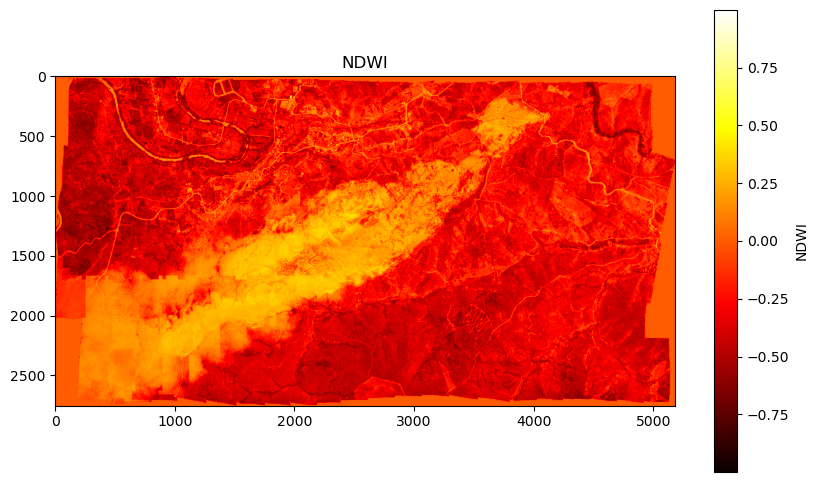

In [3]:
index_names = ["BAI", "NDVI", "NDWI"]
    
bai = 1 / ((red - 0.1) ** 2 + (nir - 0.06) ** 2 + 1e-6)
ndvi = (nir - red) / (nir + red + 1e-6)
ndwi = (green - nir) / (nir + green + 1e-6)

indices = np.stack([bai, ndvi, ndwi], axis=0)
        
# Save each index separately
for i, index in enumerate(indices):
    output_tiff = folder + f"{index_names[i]}_index.tiff"
    profile.update(
        dtype=rasterio.float32,
        count=1,  # Single-band output for each index
        driver="GTiff",
        compress='LZW',  # Reduce file size without losing precision
        tiled=True  # Might improve compatibility with GIS tools
    )
    with rasterio.open(output_tiff, "w", **profile) as dst:
        dst.write(index, 1)  # Write the index as the first band
    print(f"Index {index_names[i]} saved to {output_tiff}")

# Function to plot indices
def plot_index(index, title, cmap='hot', log_scale=False):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if log_scale:
        plt.imshow(np.log1p(index), cmap=cmap)
    else:
        plt.imshow(index, cmap=cmap)
    plt.colorbar(label=title)
    plt.show()

# Plot results
for i, index in enumerate(indices):
    plot_index(index, index_names[i], log_scale=(index_names[i] in ["BAI"]))


## Creating and Saving the LNV.tiff

In this code, we are generating a new raster file called **LNV.tiff**, which contains three bands:

1. **LWIR (Long-Wave Infrared)**: Represents thermal data, which is useful for detecting temperature variations in the image.
2. **NIR (Near-Infrared)**: Captures data in the near-infrared spectrum, which is critical for vegetation analysis and identifying heat signatures.
3. **Visible**: This is computed using the formula:

   \[
   \text{Visible} = 0.299 \cdot \text{Red} + 0.587 \cdot \text{Green} + 0.114 \cdot \text{Blue}
   \]

   The **Visible** band combines the red, green, and blue bands to create a representation of what is seen by the human eye, helping to enhance the visual context of the data.

### Why is LNV Useful?

The **LNV.tiff** file is particularly useful for a variety of remote sensing and environmental applications, including:

- **Fire Detection**: The combination of LWIR and NIR bands helps identify heat signatures, which are crucial for detecting fire hotspots. The **LWIR** band helps identify areas of high temperature (e.g., fire), while the **NIR** can be used to monitor the health of vegetation (fires often cause significant damage to plants).
  
- **Vegetation and Land Cover Monitoring**: The **NIR** band is highly sensitive to vegetation and is used in vegetation indices like NDVI. By combining this with the visible band, we can monitor land cover changes over time, including the impact of fires or other environmental phenomena.
  
- **Enhanced Visualization**: The **Visible** band, computed from the RGB bands, provides an intuitive representation of the data, allowing analysts to visually interpret the thermal and infrared information more easily.

### Code Explanation

1. **Visible Index Calculation**: The visible index is calculated by combining the RGB bands using weighted values that represent the relative contributions of red, green, and blue to the visible spectrum. This helps create a realistic image representation of the scene.

2. **Band Stacking**: The three bands (LWIR, NIR, and Visible) are stacked together into a single multi-band raster. This makes it easier to analyze and visualize the data as a cohesive unit.

3. **Saving the Output**: The resulting raster, **LNV.tiff**, is saved as a GeoTIFF with the three bands. The profile of the original RGBN image is copied and updated to accommodate the new bands and ensure compatibility with GIS tools. The file is compressed using **LZW** compression to reduce file size without losing data quality.

By creating and saving the **LNV.tiff**, we are preparing a valuable dataset for fire detection, environmental monitoring, and other geospatial analyses.


In [4]:
output_tiff = folder + "LNV.tiff"

# Calculate the visible index using the formula
visible = (0.299 * red) + (0.587 * green) + (0.114 * blue)

# Stack the bands together: LWIR, NIR, and visible
indices = np.stack([lwir*255., nir*255., visible*255.], axis=0)

profile.update(
    dtype=rasterio.float32,
    count=3,  # 3 bands: LWIR, NIR, visible
    driver="GTiff",
    compress='LZW',  # Compression for smaller file size
    tiled=True  # Enable tiling for compatibility with GIS tools
)

# Save the new TIFF with the 3 bands
with rasterio.open(output_tiff, "w", **profile) as dst:
    for i, index in enumerate(indices, start=1):
        dst.write(index, i)

print(f"LNV.tiff saved to {output_tiff}")

LNV.tiff saved to AirborneData/20240913175528/LNV.tiff


## Calculating the LWIR/NIR Ratio

The **LWIR/NIR ratio** is a critical index for detecting heat signatures and understanding thermal patterns in a scene. By comparing the **LWIR (Long-Wave Infrared)** and **NIR (Near-Infrared)** bands, this ratio can highlight areas of high temperature or significant thermal activity, which is especially useful for **fire detection**.

### Why is the LWIR/NIR Ratio Useful?

- **Fire Detection**: The **LWIR** band captures thermal information, which is essential for identifying heat sources, such as fires. The **NIR** band helps monitor vegetation and other land cover types. A higher ratio of LWIR to NIR may indicate elevated temperatures or fire-related phenomena, making this ratio a valuable tool for detecting hotspots or active fires in remote sensing data.
  
- **Thermal Anomalies**: This ratio can also be used to detect thermal anomalies in other scenarios, such as industrial areas or regions with significant temperature variation.

### Code Explanation

The code below computes the ratio between the **LWIR** and **NIR** bands, and saves the result as a **GeoTIFF** file. The ratio is calculated pixel-wise for each corresponding value in the LWIR and NIR bands.

In [5]:
output_tiff = folder + "LNIR.tiff"

# Calculate the LWIR/NIR ratio (avoid division by zero by adding a small constant)
lnir_ratio = lwir*255. / (nir*255. + 1e-6)

profile.update(
    dtype=rasterio.float32,
    count=1,  # 1 band
    driver="GTiff",
    compress='LZW',  # Compression for smaller file size
    tiled=True  # Enable tiling for compatibility with GIS tools
)

# Save the ratio as a new TIFF file
with rasterio.open(output_tiff, "w", **profile) as dst:
    dst.write(lnir_ratio, 1)  # Write the ratio as the first band

print(f"LWIR/NIR ratio saved to {output_tiff}")


LWIR/NIR ratio saved to AirborneData/20240913175528/LNIR.tiff
